In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import GA_lib as GA
import copy

In [2]:
data=pd.read_csv("ASIA_DATA.csv")
dag_true=pd.read_csv("DAGtrue_ASIA.csv")


In [3]:
# Number of samples 
N_samples=5000
data_sampled=data.sample(N_samples)
data_sampled=data_sampled.astype('category')


In [4]:


# Read the CSV file into a DataFrame
df = dag_true
# Define the desired topological order
topological_order =list(data.columns)

# Create a list of unique variables (nodes)
nodes = np.unique(df[['Variable 1', 'Variable 2']].values)

# Initialize an empty adjacency matrix filled with zeros
num_nodes = len(nodes)
adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

# Iterate through the DataFrame and update the adjacency matrix based on dependencies
for _, row in df.iterrows():
    var1 = row['Variable 1']
    var2 = row['Variable 2']
    dependency = row['Dependency']

    # Find the indices of var1 and var2 in the topological order list
    index1 = topological_order.index(var1)
    index2 = topological_order.index(var2)

    # Set the corresponding entry in the adjacency matrix to 1
    if dependency == '->':
        adjacency_matrix[index1, index2] = 1

print("Adjacency Matrix (in topological order):")
print(adjacency_matrix)

Adjacency Matrix (in topological order):
[[0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 1 1 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


In [5]:
def tournoment( obj1, obj2):
    if(obj1.cost>obj2.cost):
        return 1
    else:
        return 0

In [6]:
n=adjacency_matrix.shape[0]
vector_length = int(n*(n-1)*0.5)
# Define the probabilities
probabilities = [1/vector_length, (vector_length-2)/vector_length, 1/vector_length]
Pop_size = np.array(range(100))



In [7]:
def otimizador_func(obj):
    obj.evaluate_cost()
    obj_old_cost=obj.cost
    # Deep copy (new copies of all objects referenced within obj)
    obj_old_deep = copy.deepcopy(obj)
    #obj_old=obj
    obj.mutate()
    obj.evaluate_cost()
    i=0
    while(i<obj.adjacency_matrix.shape[0]):


        #print("obj_old_cost :", obj_old_cost)
        #print("obj_old_deep.cost :", obj_old_deep.cost)
        #print("obj.cost   :", obj.cost)

        if(obj.cost>obj_old_cost):
            obj_old_deep = copy.deepcopy(obj)
            obj_old_cost=obj_old_deep.cost
            #print("Entrei")
        else:
            obj=copy.deepcopy(obj_old_deep)
            obj.mutate()
            obj.evaluate_cost()
            #print("nao entrei")
        i=i+1
        
        



    #print("obj_old_deep:", obj_old_deep.cost)
    #print("custo atual :", obj.cost)
    return obj_old_deep

In [8]:
n=adjacency_matrix.shape[0]
mask=np.triu(np.ones([n,n]), k=1)
rows, cols = np.where(mask)
index = np.array([rows, cols]).T

In [9]:
#Creating initial population

object_list = []
for i in range(100):
    vector = np.random.choice([-1, 0, 1], size=vector_length, p=probabilities)
    obj=GA.BayesianNetworkIndividual.from_bit_representation(vector,data_sampled,index=index)
    cost=obj.evaluate_cost()
    object_list.append(obj)
    
sorted_people = sorted(object_list, key=lambda obj:obj.cost,reverse = True)

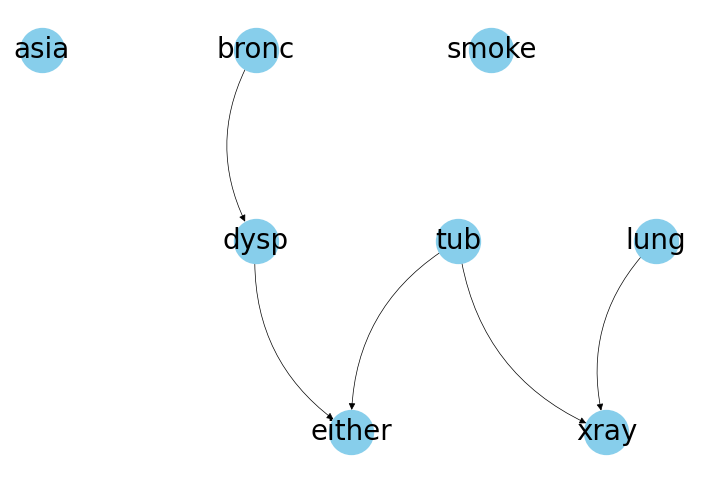

In [10]:
GA.plot_digraph(sorted_people[0].adjacency_matrix,data_sampled.columns)

In [11]:
### GA body
best_fit=[]
max_interations=1000
pc=0.1
pm=0.8
po=0.5
n_pais=4
for j in range(max_interations):
    # parents selection
    parents=[]
    for i in range(n_pais):
        selected_torneio=np.random.choice(Pop_size, size=2, replace=False)
        # Access the selected individuals from the sorted_people list
        selected_individuals = [sorted_people[index] for index in selected_torneio]
        #selected_individuals
        result = tournoment(selected_individuals[0], selected_individuals[1])
        parents.append(selected_individuals[result])

    # Crossover
    filhos=[]
    for i in  range(0, n_pais, int(n_pais/2)):
        if(pc>np.random.rand()):
            #parents[i]=otimizador_func(parents[i])
            f1,f2 =parents[i].crossover(parents[i+1])
            filhos.extend([f1,f2])
        else:
            filhos.extend([parents[i],parents[i+1]])

    # Mutation & cost evaluation
    for i in range(n_pais):
        if(pm>np.random.rand()):
            filhos[i].mutate()
        filhos[i].evaluate_cost()
    
    if(po>np.random.rand()):
            inx=np.random.choice(n_pais,1)[0]
            filhos[inx]=otimizador_func(filhos[inx])

    # Sorting acording to cost function 
    sorted_people.extend(filhos)
    sorted_people = sorted(sorted_people, key=lambda obj:obj.cost,reverse = True)

    for _ in range(n_pais):
        sorted_people.pop()

    best_fit.append(sorted_people[0].cost)

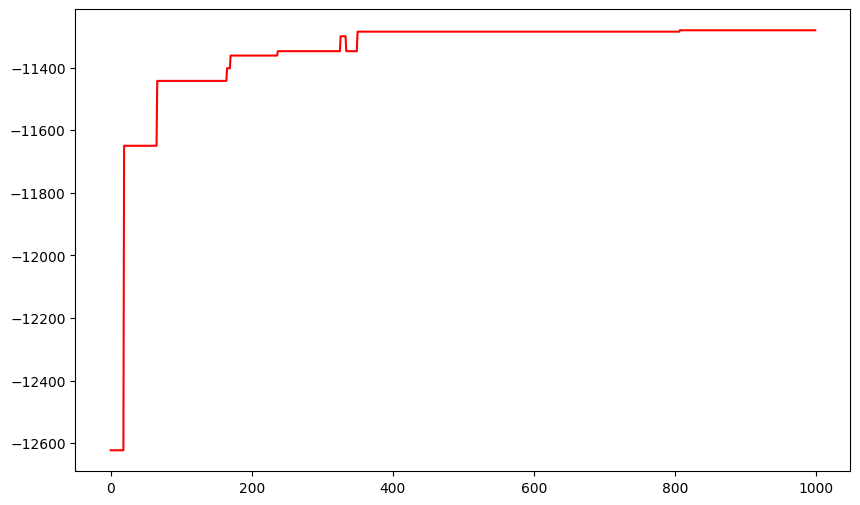

In [12]:
# Create a time array for the x-axis
interacoes = np.arange(0, max_interations)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(interacoes, best_fit, label='best_fit', color='red')

In [13]:
sorted_people[0].cost

-11280.9009000112

In [14]:
sorted_people[0].adjacency_matrix

array([[0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0],
       [0, 1, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 1, 1],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

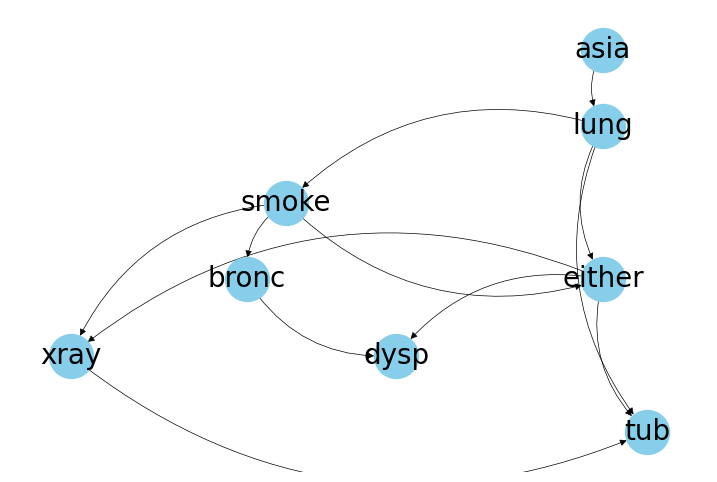

In [15]:
GA.plot_digraph(sorted_people[0].adjacency_matrix,data_sampled.columns)

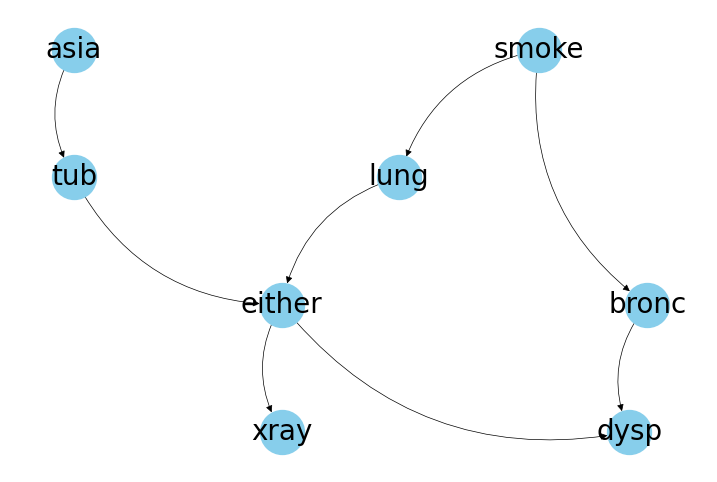

-11245.390560001295

In [16]:
GA.plot_digraph(adjacency_matrix,data_sampled.columns)

ground=GA.BayesianNetworkIndividual(adjacency_matrix,data_sampled)
ground.evaluate_cost()
ground.cost